# Dynamic Mode Decomposition

### Sources 

* *Chapter 7.2 of [Data-Driven Science and Engineering by Brunton and Kutz](http://www.databookuw.com)*

* *[On Dynamic Mode Decomposition: Theory and Applications](https://arxiv.org/pdf/1312.0041.pdf) by Tu, Rowley, Luchtenberg, Brunton, and Kutz (2013)*

## Derivation


Dynamic mode decomposition (DMD) is a method of finding a low-rank representation of the Koopman matrix $A$ that operates on a sequence of measurement snapshot pairs $\{ \mathbf{x}(t_k), \mathbf{x}(t_k')\}$ from a dynamical system.
That is,
\begin{align}
\mathbf{x}(t_k') = A \mathbf{x}(t_k)
\end{align}

The snapshot pairs are assembled into matrices
\begin{align}
X &= [\mathbf{x}(t_1), \mathbf{x}(t_2), \dots, \mathbf{x}(t_m) ]\\
X' &= [\mathbf{x}(t_1'), \mathbf{x}(t_2'), \dots, \mathbf{x}(t_m') ]
\end{align}
so that
\begin{align}
X' = A X.
\end{align}
The full-rank matrix $A$ can be found directly using the pseudo-inverse,
\begin{align}
A = X' X^\dagger.
\end{align}

However, if the state dimension $n$ is very large, this could be computationally intractable, so we desire to find an approximation $\tilde{A}$ with rank $r \ll n$ that still captures the dominating dynamics of the system.
The DMD finds this approximation, and importantly, it finds the dominating dynamic modes (eigenvectors) $\Phi$ of the high dimensional system.
These can then be used to form a reduced-dimension system that still captures the dynamics of the high-dimensional system.

## DMD algorithm for $\tilde{A}$

1. Compute the rank-reduced SVD of $X$.

\begin{align}
X \approx \tilde{U} \tilde{\Sigma} \tilde{V}^H
\end{align}

2. Compute the reduced matrix $\tilde{A}$

\begin{align}
\tilde{A} = \tilde{U}^H X' \tilde{V} \tilde{\Sigma}^{-1}
\end{align}

## DMD algorithm for $\Phi$

3. Find the eigenvectors ($W$) and eigenvalues ($\Lambda$) of $\tilde{A}$.

\begin{align}
\tilde{A} W = W \Lambda
\end{align}

4. Compute the high-dimensional DMD modes

\begin{align}
\Phi = X' \tilde{V} \tilde{\Sigma}^{-1} W
\end{align}


In [87]:
using LinearAlgebra

function DMD(X, Xprime, r)
    U, S, V = svd(X, full=false)
    
    Utilde = U[:, 1:r]
    Stilde = S[1:r]
    Vtilde = V[:, 1:r]
    
    Atilde = Utilde' * Xprime * Vtilde * diagm(Stilde.^(-1))
    
    W = eigvecs(Atilde)
    Lambda = eigvals(Atilde)
    Phi = Xprime * Vtilde * diagm(Stilde.^-1) * W
    
    return Atilde, Utilde, Phi, W, Lambda
end


DMD (generic function with 1 method)

In [8]:
A = [0. 1. 0.; 
     0. 0. -2.;
     .5 0. 0.]

x0 = [1., 0., 0.]

n = length(x0)
m = 10

X = zeros(n, m)

X[:,1] = x0

for i = 2:m
    X[:,i] = A * X[:,i-1]
end

X

3×10 Matrix{Float64}:
 1.0  0.0   0.0  -1.0   0.0  0.0  1.0  0.0   0.0  -1.0
 0.0  0.0  -1.0   0.0   0.0  1.0  0.0  0.0  -1.0   0.0
 0.0  0.5   0.0   0.0  -0.5  0.0  0.0  0.5   0.0   0.0

In [10]:
Atilde, Utilde, Phi, W, Lambda = DMD(X[:,1:m-1], X[:,2:m], 3)
@show Atilde
@show Phi

Atilde = [0.0 0.0 -2.0; 1.0000000000000002 0.0 3.2049378106392735e-16; 0.0 0.5 0.0]
Phi = ComplexF64[-0.666666666666667 + 0.0im -0.6666666666666666 - 9.251858538542979e-17im -0.6666666666666666 + 9.251858538542979e-17im; 0.6666666666666669 + 0.0im -0.3333333333333327 + 0.5773502691896262im -0.3333333333333327 - 0.5773502691896262im; 0.3333333333333333 + 0.0im -0.16666666666666669 - 0.2886751345948128im -0.16666666666666669 + 0.2886751345948128im]


3×3 Matrix{ComplexF64}:
 -0.666667+0.0im  -0.666667-9.25186e-17im  -0.666667+9.25186e-17im
  0.666667+0.0im  -0.333333+0.57735im      -0.333333-0.57735im
  0.333333+0.0im  -0.166667-0.288675im     -0.166667+0.288675im

In [11]:
eigvecs(A)

3×3 Matrix{ComplexF64}:
 -0.666667+0.0im  0.666667-0.0im       0.666667+0.0im
  0.666667+0.0im  0.333333-0.57735im   0.333333+0.57735im
  0.333333+0.0im  0.166667+0.288675im  0.166667-0.288675im

In [12]:
Phi

3×3 Matrix{ComplexF64}:
 -0.666667+0.0im  -0.666667-9.25186e-17im  -0.666667+9.25186e-17im
  0.666667+0.0im  -0.333333+0.57735im      -0.333333-0.57735im
  0.333333+0.0im  -0.166667-0.288675im     -0.166667+0.288675im

In [16]:
println("\nFull state propagation")
@show A * x0
println("\nDMD state propagation, projected into full state")
@show Utilde * Atilde * Utilde' * x0
println("\nReconstructed A propagation")
@show real.((Phi) * diagm(Lambda) * pinv(Phi) * x0)
;


Full state propagation
A * x0 = [0.0, 0.0, 0.5]

DMD state propagation, projected into full state
Utilde * Atilde * Utilde' * x0 = [0.0, 0.0, 0.5]

Reconstructed A propagation
real.(Phi * diagm(Lambda) * pinv(Phi) * x0) = [8.881784197001252e-16, 1.6653345369377348e-16, 0.5000000000000004]


## Large state
Here we use DMD to find the dominating modes for a larger state - a $100 \times 100$ pixel image with a bar sliding across it from left to right. 

In [21]:
using Plots

┌ Info: Saved animation to 
│   fn = /home/jbwillis/research/notebooks/GeneralNotebooks/Control/figs/DMD_original_heatmap.gif
└ @ Plots /home/jbwillis/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/jbwillis/research/notebooks/GeneralNotebooks/Control/figs/DMD_original_heatmap.gif")
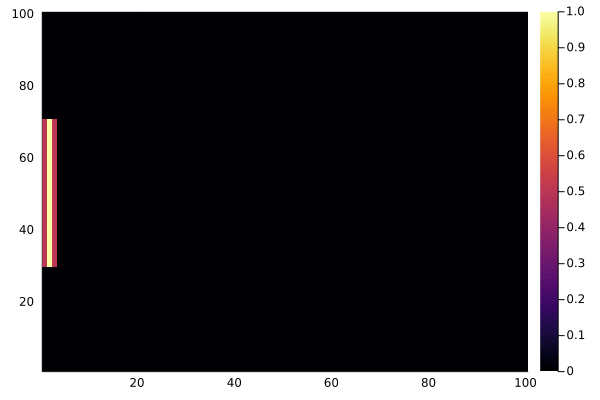

In [102]:
s = 100 # dimension of a side
n = s^2 # state dimension

a = 30
b = 70

m = s-2
X = zeros(n, m)

anim = Animation()
for i = 2:m+1
    
    XX = zeros( s, s)
    XX[a:b,i-1] .= 0.5
    XX[a:b,i] .= 1.0
    XX[a:b,i+1] .= 0.5

    X[:,i-1] = deepcopy(reshape(XX, :))
    
    heatmap(XX)
    frame(anim)
end
gif(anim, "figs/DMD_original_heatmap.gif", fps = 15)

┌ Info: Saved animation to 
│   fn = /home/jbwillis/research/notebooks/GeneralNotebooks/Control/figs/DMD_Phi_heatmap.gif
└ @ Plots /home/jbwillis/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/jbwillis/research/notebooks/GeneralNotebooks/Control/figs/DMD_Phi_heatmap.gif")
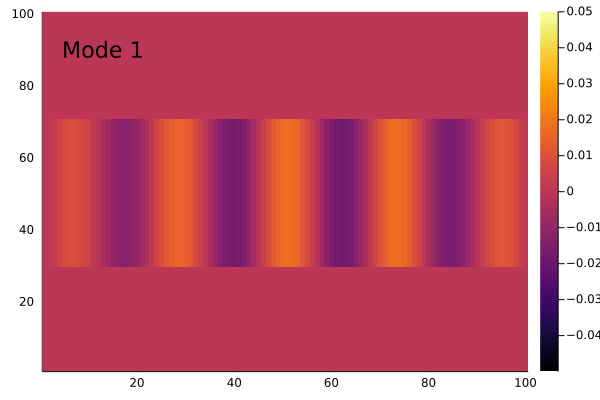

In [104]:
r = 10
Atilde, Utilde, Phi, W, Lambda = DMD(X[:,1:m-1], X[:,2:m], r)

anim2 = Animation()
for i = 1:size(Phi, 2)
    rPhi_i = reshape(real.(Phi[:,i]), s, s)
    heatmap(rPhi_i, clim=(-0.05,0.05))
    annotate!(5, 90, text("Mode $i", :black, :left, 15))
    frame(anim2)
end
gif(anim2, "figs/DMD_Phi_heatmap.gif", fps=5)

┌ Info: Saved animation to 
│   fn = /home/jbwillis/research/notebooks/GeneralNotebooks/Control/figs/DMD_xrecon_heatmap.gif
└ @ Plots /home/jbwillis/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/jbwillis/research/notebooks/GeneralNotebooks/Control/figs/DMD_xrecon_heatmap.gif")
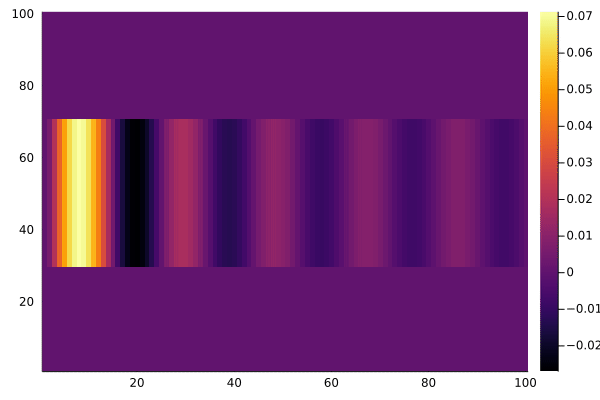

In [105]:
xtilde1 = Utilde' * X[:,1]

b = (W * diagm(Lambda)) \ xtilde1

anim3 = Animation()
for i = 2:m+1
   
    x_i = real.(Phi * diagm(Lambda.^(i-1)) * b)
    
    heatmap(reshape(x_i, s, s))
    frame(anim3)    
end

gif(anim3, "figs/DMD_xrecon_heatmap.gif", fps=15)
    